In [31]:
import pandas as pd
# Load the CSV file (replace 'your_file.csv' with the actual file name)
df = pd.read_csv("mogi_tphcm_houses_cleaned_filtered_v2.csv")

In [32]:
df = df[df['Price_USD'] <= 800000]  # Houses ≤ $800K

In [37]:
df = df[df['Distance_km_to_centre'] <= 15]  # Houses ≤ $800K

In [58]:
df = df[df['Area'] <= 125]


In [62]:
df = df[df['Price_per_m2'] <= 12500]

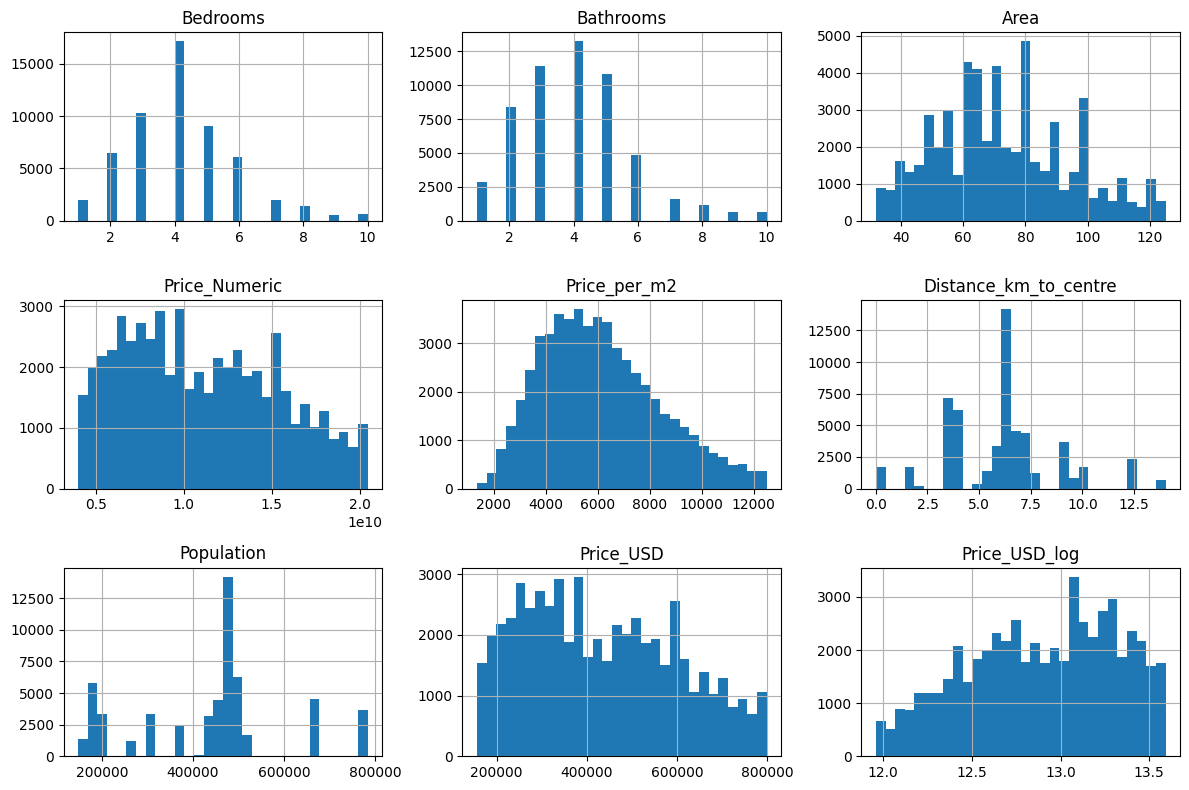

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot histograms for numerical features
df.hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()


<Axes: >

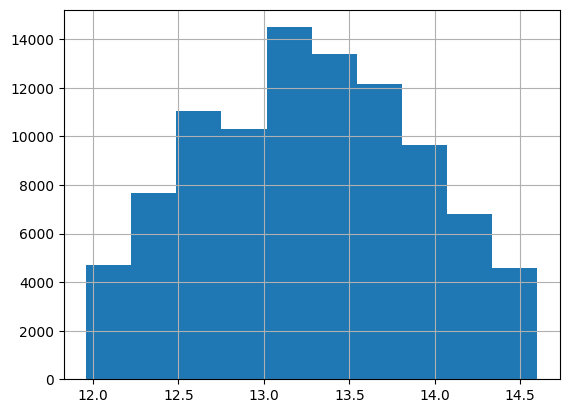

In [25]:
df["Price_USD_log"].hist()

In [47]:
df.describe()

,Bedrooms,Bathrooms,Area,Price_Numeric,Price_per_m2,Distance_km_to_centre,Population,Price_USD,Price_USD_log
count,56994.000000,56994.000000,56994.000000,5.699400e+04,56994.000000,56994.000000,56994.000000,56994.000000,56994.000000
mean,4.191652,4.010615,72.102906,1.119180e+10,6352.921051,5.980400,431507.477015,437393.357718,12.905908
std,1.709530,1.761440,21.582613,4.362551e+09,2637.705318,2.667056,166394.242558,170495.391118,0.418221
min,1.000000,1.000000,32.000000,4.000000e+09,1359.359402,0.000000,147168.000000,156326.331216,11.959707
25%,3.000000,3.000000,56.000000,7.500000e+09,4441.088955,3.834019,310178.000000,293111.871031,12.588313
50%,4.000000,4.000000,70.000000,1.090000e+10,5932.025961,6.289203,474792.000000,425989.252565,12.962172
75%,5.000000,5.000000,86.000000,1.450000e+10,7771.905671,7.148581,490620.000000,566682.950660,13.247557
max,10.000000,10.000000,125.000000,2.045000e+10,24425.989253,14.024251,784173.000000,799218.368344,13.591391


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select features
X = df[['Bedrooms', 'Bathrooms', 'Area', 'Population', 'Distance_km_to_centre']]
y = np.log1p(df['Price_USD_log'])  # Log transformation

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Fit and transform all data

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("Training Samples:", len(X_train))
print("Test Samples:", len(X_test))


Training Samples: 45595
Test Samples: 11399


In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Build the model
model = keras.Sequential([
    layers.Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)  # Predicts log-transformed prices
])

# Compile the model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train with early stopping
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.2,  # Use part of training data for validation
                    epochs=100, batch_size=512,
                    callbacks=[early_stop], verbose=1)


Epoch 1/100
72/72 [==============================] - 1s 4ms/step - loss: 1.9877 - mae: 1.1402 - val_loss: 0.4420 - val_mae: 0.5450
Epoch 2/100
72/72 [==============================] - 0s 2ms/step - loss: 0.2599 - mae: 0.4076 - val_loss: 0.0959 - val_mae: 0.2445
Epoch 3/100
72/72 [==============================] - 0s 3ms/step - loss: 0.0323 - mae: 0.1286 - val_loss: 0.0088 - val_mae: 0.0677
Epoch 4/100
72/72 [==============================] - 0s 2ms/step - loss: 0.0054 - mae: 0.0541 - val_loss: 0.0039 - val_mae: 0.0456
Epoch 5/100
72/72 [==============================] - 0s 2ms/step - loss: 0.0029 - mae: 0.0397 - val_loss: 0.0024 - val_mae: 0.0357
Epoch 6/100
72/72 [==============================] - 0s 3ms/step - loss: 0.0020 - mae: 0.0337 - val_loss: 0.0018 - val_mae: 0.0314
Epoch 7/100
72/72 [==============================] - 0s 3ms/step - loss: 0.0016 - mae: 0.0303 - val_loss: 0.0015 - val_mae: 0.0288
Epoch 8/100
72/72 [==============================] - 0s 2ms/step - loss: 0.0014 - m

In [50]:
y_pred_log = model.predict(X_test)
y_pred_actual = np.expm1(y_pred_log)

357/357 [==============================] - 0s 630us/step


In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Get predictions on test data
y_pred_log = model.predict(X_test)

# Convert predictions back to actual prices
y_pred_actual = np.expm1(y_pred_log)  # Reverse log transformation
y_test_actual = np.expm1(y_test)  # Convert test set back to original scale

# Calculate MAE, MSE, RMSE, and R²
mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred_actual)

# Print evaluation results
print(f"Mean Absolute Error (MAE): {mae:,.2f}")
print(f"Mean Squared Error (MSE): {mse:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")


357/357 [==============================] - 0s 479us/step
Mean Absolute Error (MAE): 0.26
Mean Squared Error (MSE): 0.11
Root Mean Squared Error (RMSE): 0.33
R² Score: 0.3600
